In [434]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS
from tqdm.auto import tqdm
import seaborn as sns
import math
import pickle
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode
from scipy import interpolate
from pathlib import Path
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from analysis.pose_utils import plot_regression, colorline, pixels2cm
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.strikes.strikes import Loader, StrikeAnalyzer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [387]:
orm = ORM()
FIGURE_PATH = '../notebooks/figures'
BAD_ANIMALS = ['PV03', 'PV26', 'PV72', 'PV87', 'PV88', 'PV90', 'PV101', 'PV119', 'PV144']
SCREEN_Y_POS = {'reptilearn4': -3, 'msi-regev': 0.06}

In [390]:
with orm.session() as s:
    orm_res = s.query(Strike, Block, Experiment).join(Block, Block.id == Strike.block_id).join(Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena.in_(['reptilearn4', 'msi-regev']),
        Experiment.animal_id.not_in(BAD_ANIMALS),
        Experiment.animal_id.startswith('PV'),
        Experiment.start_time > '2023-04-18'
    ).all()

In [391]:
def analyze_db_data():
    df_ = []
    for strk, blk, exp in orm_res:
        miss_distance = np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2)
        df_.append({'strike_id': strk.id, 'time': strk.time, 'animal_id': exp.animal_id, 'miss_distance': miss_distance,
                    'pred_distance': strk.prediction_distance, 'movement_type': blk.movement_type, 
                    'calc_speed': strk.calc_speed, 'proj_strike': strk.projected_strike_coords, 'bug_size': strk.bug_size,
                    'proj_bug_x': strk.projected_leap_coords and strk.projected_leap_coords[0], 'is_hit': strk.is_hit, 
                    'trial_id': strk.trial_id, 'block_id': blk.id, 'arena_name': exp.arena})

    df_ = pd.DataFrame(df_)
    df_['day'] = df_.time.dt.floor('d').copy()
    df_['trial_id'] = df_.trial_id.astype('Int32')
    df_['proj_strike_x'] = df_.proj_strike.map(lambda x: x[0] if x and len(x)==2 else None)
    df_['proj_strike_y'] = df_.proj_strike.map(lambda x: x[1] if x and len(x)==2 else None)
    df_['movement_type'] = df_.movement_type.replace({'low_horizontal': 'random_low_horizontal'})
    df_.drop(columns=['proj_strike'], inplace=True)

    for animal_id in df_.animal_id.unique():
        af_ = df_.query(f'animal_id=="{animal_id}"').sort_values(by='strike_id')
        first_day = af_.day.sort_values().iloc[0]
        df_.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
    df_.sort_values(by='time')
    return df_

df = analyze_db_data()
df.head()

,strike_id,time,animal_id,miss_distance,pred_distance,movement_type,calc_speed,bug_size,proj_bug_x,is_hit,trial_id,block_id,arena_name,day,proj_strike_x,proj_strike_y,day_num
0,3093,2023-05-24 10:00:54.573,PV42,45.607017,0.779532,jump_up,4.140111,163,-68.0,True,11947,1572,msi-regev,2023-05-24,-36.0,-28.0,26.0
1,3094,2023-05-24 10:04:03.744,PV42,77.103826,0.320173,jump_up,4.046848,143,-60.0,True,11954,1572,msi-regev,2023-05-24,-77.0,-4.0,26.0
2,107,2023-04-22 10:01:32.224,PV85,33.955854,0.249356,random_low_horizontal,2.100104,165,-22.0,True,6414,1031,msi-regev,2023-04-22,-33.0,-8.0,4.0
3,108,2023-04-22 10:04:15.172,PV85,19.235384,0.173923,random_low_horizontal,2.085246,163,-28.0,True,6420,1031,msi-regev,2023-04-22,-19.0,-3.0,4.0
4,110,2023-04-22 10:05:10.516,PV85,43.416587,0.443417,random_low_horizontal,2.066818,146,-26.0,True,6349,1031,msi-regev,2023-04-22,-38.0,-21.0,4.0


In [24]:
sns.set_context('paper', font_scale=1.4)
PLT_COLORS = list(TABLEAU_COLORS.values()) + list(CSS4_COLORS.values())
COLORS = {
    'PV42': '#1f77b4',
    'PV85': '#ff7f0e',
    'PV91': '#2ca02c',
    'PV80': '#d62728',
    'PV97': '#9467bd',
    'PV88': '#8c564b',
    'PV99': '#e377c2'
}
PLT_COLORS = [c for c in PLT_COLORS if c not in COLORS.values()]
COLORS.update({
    aid: PLT_COLORS[i] for i, aid in enumerate([a for a in df.animal_id.unique() if a not in COLORS.keys()])
})
COLORS

{'PV42': '#1f77b4',
 'PV85': '#ff7f0e',
 'PV91': '#2ca02c',
 'PV80': '#d62728',
 'PV97': '#9467bd',
 'PV88': '#8c564b',
 'PV99': '#e377c2',
 'PV148': '#7f7f7f',
 'PV82': '#bcbd22',
 'PV43': '#17becf'}

# Figure 1

In [ ]:
def interpolate_y(pose_df, kind='quadratic'):
    nan_idx = pose_df.index[pose_df.y.isna()].tolist()
    no_nan_idx = pose_df.index[~pose_df.y.isna()].tolist()
    if len(no_nan_idx) == 0:
        return
    time = (pose_df.time - pose_df.time.iloc[0]).dt.total_seconds()
    intr = interpolate.interp1d(time.loc[no_nan_idx].values, pose_df.y.loc[no_nan_idx].values, kind=kind)
    inter_y = pose_df.y.copy()
    for i in nan_idx:
        try:
            inter_y.loc[i] = intr(time.loc[i])
        except Exception:
            continue
    return inter_y.values


def time_to_feeder(animal_ids=None, y_thresh=9, min_blocks=30, n_blocks=50):
    if animal_ids is None:
        animal_ids = df.animal_id.unique().tolist()
    else:
        animal_ids = [animal_ids] if isinstance(animal_ids, str) else animal_ids
    
    feeder_times_ = {}
    with orm.session() as s:
        exps = s.query(Experiment).filter(Experiment.animal_id.in_(animal_ids),
                                          Experiment.start_time > '2023-04-01').all()
        for exp in tqdm(exps):
            animal_id = exp.animal_id
            if animal_id in feeder_times_ and len(feeder_times_[animal_id]) > n_blocks:
                continue
            block_strikes = []
            for blk in exp.blocks:
                strike_ids = [(strk.id, strk.time) for strk in blk.strikes if strk.is_hit]
                strike_ids = sorted(strike_ids, key=lambda x: x[1])
                for sid, _ in strike_ids:
                    try:
                        ld = Loader(int(sid), 'front', orm=orm, sec_before=0, sec_after=30, is_debug=False)
                        sa = StrikeAnalyzer(ld)
                        if all(sa.pose_df.y.isna()):
                            # print(f'SID={sid} - All pose Y values are NaN')
                            continue
                        y = interpolate_y(sa.pose_df)
                        idx = y > y_thresh
                        if not any(idx):
                            # print(f'SID={sid} - No y coordinates above {y_thresh}')
                            continue
                        t0 = sa.pose_df.loc[idx].sort_values(by='time').time.iloc[0]
                        t_feeder = (t0 - sa.pose_df.time.iloc[0]).total_seconds()
                        block_strikes.append(t_feeder)
                    except Exception as exc:
                        continue
            
            if block_strikes:
                feeder_times_.setdefault(animal_id, []).append({'block_time': blk.start_time,
                                                                'time2feeder': np.mean(block_strikes)})
        
    for animal_id in feeder_times_.copy().keys(): 
        if len(feeder_times_[animal_id]) < min_blocks:
            del feeder_times_[animal_id]
            continue
        feeder_times_[animal_id] = pd.DataFrame(feeder_times_[animal_id]).sort_values('block_time')
    
    with open('../notebooks/figures/cache/time2feeder.pkl', 'wb') as f:
        pickle.dump(f, feeder_times_)
        
    return feeder_times_


def plot_time2feeder(feeder_times_: dict, example_animal, n_blocks=60, min_blocks=10, animals2drop=(), axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    
    for animal_id, ft0 in feeder_times_.items():
        if len(ft0) < min_blocks or animal_id in animals2drop:
            continue    
        
        ft = ft0.copy().iloc[:n_blocks].reset_index()
        plot_regression(axes[1], ft.index.values, ft['time2feeder'].values, color=COLORS[animal_id], prefix=animal_id)
        
        if animal_id == example_animal:
            plot_regression(axes[0], ft.index.values, ft['time2feeder'].values, color=COLORS[animal_id])
            axes[0].scatter(ft.index.values, ft['time2feeder'].values, color=COLORS[animal_id])
            axes[0].set_xlabel('Block Number')
            axes[0].set_ylabel('Time to reach reward [sec]')
            axes[0].grid(False)
        
    axes[1].set_xlabel('Block Number')
    axes[1].set_ylabel('Time to reach reward [sec]')
    axes[1].grid(False)
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
# load or run

# feeder_times = time_to_feeder()

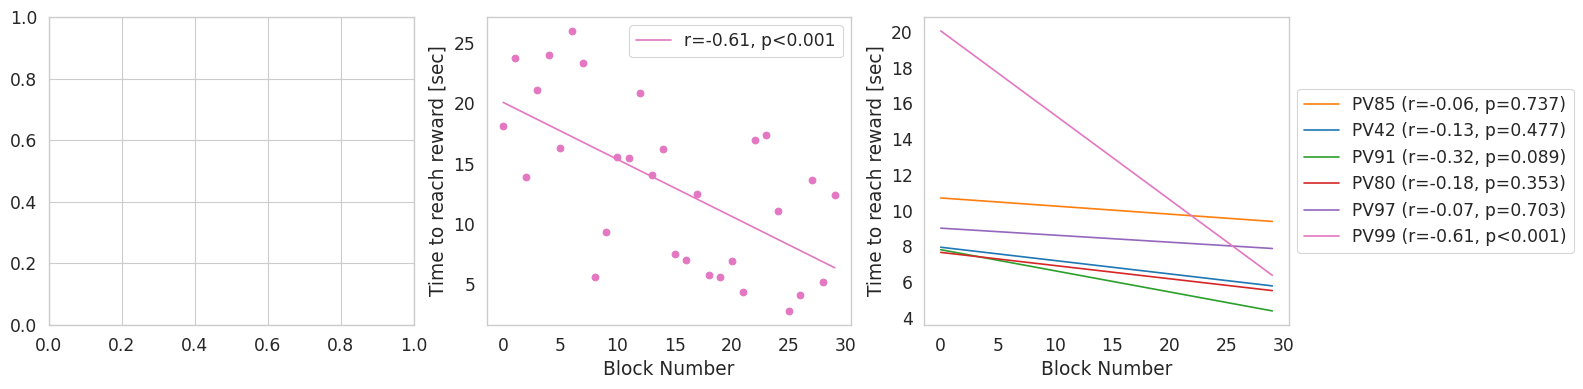

In [373]:
def plot_figure1():
    with open(f'{FIGURE_PATH}/cache/time2feeder.pkl', 'rb') as f:
        feeder_times = pickle.load(f)
        
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    plot_time2feeder(feeder_times, 'PV99', n_blocks=30, animals2drop=[], axes=axes[1:])
    
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure1.pdf')
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure1.png')
    
plot_figure1()

# Figure 2

### Strikes Dynamics

In [403]:
metrics = {'y': 'Lizard Position [cm]', 'velocity_y': 'Lizard Velocity [cm/sec]'}

def calc_strikes_dynamics(movement_type=None, speeds=(2,6), animal_id=None, only_hits=True, is_cache=True):
    cache_file = Path(f'../notebooks/figures/cache/sd_res_{animal_id}.pkl')
    if is_cache and cache_file.exists():
        with cache_file.open('rb') as f:
            res = pickle.load(f)
    else:
        df_ = df.copy()
        if movement_type:
            df_ = df_.query(f'movement_type=="{movement_type}" and is_hit')
        screen_y_pos = 0
        if animal_id:
            df_ = df_.query(f'animal_id=="{animal_id}"')
            arena_name = df_.arena_name.iloc[0]
            screen_y_pos = SCREEN_Y_POS[arena_name]
        if only_hits:
            df_ = df_.query(f'is_hit')
        df_ = df_.reset_index(drop=True)
        res = {k: [] for k in speeds}
    
        for i, row in df_.iterrows():
            sid = row.strike_id
            try:
                speed = round(row.calc_speed)
                if speed % 2:
                    speed -= 1
                if speed not in speeds:
                    continue
                ld = Loader(int(sid), 'front', orm=orm, is_debug=False, sec_before=2, sec_after=2)
                sa = StrikeAnalyzer(ld)
                pf = sa.pose_df
                if pf is None or pf.empty:
                    continue
                t = (pf.time - pf.time.iloc[0]).dt.total_seconds()
                z = [pf[m].values - (screen_y_pos if m == 'y' else 0) for m in metrics.keys()]
                res[speed].append((t, *z))
            except Exception:
                continue
    
        with cache_file.open('wb') as f:
            pickle.dump(res, f)
    return res

def plot_strikes_dynamics(res, speeds=(2,6), axes=None, is_plot_legend=True):
    if axes is None:
        fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))
    metrics_labels = list(metrics.keys())
    lines = []
    for metric, ax in zip(metrics_labels, axes):
        metric_id = metrics_labels.index(metric) + 1
        for i, speed in enumerate(speeds):
            lengths = [len(r[metric_id]) for r in res[speed]]
            mode_length = mode(lengths, keepdims=False).mode
            min_length = min([x for x in lengths if x > mode_length - 10])
            speed_res = [r for r in res[speed] if len(r[metric_id]) >= min_length]
            y = np.nanmean(np.vstack([r[metric_id][:min_length] for r in speed_res]), axis=0)
            t = speed_res[0][0][:min_length]
            l = ax.plot(t, y, label=f'Bug Speed={speed:.0f}cm/sec ({len(speed_res)})')
            if metric_id == len(metrics):
                lines.append(l[0])
                if is_plot_legend:
                    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        ax.set_ylabel(metrics[metric])
        ax.grid(False)
        ax.axvline(2, linestyle='--', color='k')
        ax.axhline(0, linestyle='--', color='k')
        y0, y1 = ax.get_ylim()
        if metric.startswith('velocity'):
            ax.text(2.06, (6*y0 + y1)/7, 'Strike Time', rotation=90)
        else:
            ax.text(2.06, (2*y0 + 3*y1)/5, 'Strike Time', rotation=90)
        ax.set_xlabel('Time [sec]')
    return lines

### Prediction Distance vs. Time in random_low_horizontal

In [404]:
def plot_pred_distance(ax, movement_type, speeds=(2,4,6,8), labels_fontsize=None, hit_type='all', plot_only_with_all_speeds=False):
    assert hit_type in ['all', 'misses', 'hits']
    hit_type_query = ' and is_hit' if hit_type == 'hits' else ' and not is_hit' if hit_type == 'misses' else ''
    avg = []
    lines = []
    for animal_id in df.animal_id.unique():
        af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"{hit_type_query}')[['calc_speed', 'pred_distance']].copy()
        if af_.empty:
            continue
        af_['round_speed'] = af_.calc_speed.round()
        af_ = af_.query(f'round_speed in {speeds}').copy()
        g_ = af_.groupby('round_speed').pred_distance.agg(['mean', 'sem'])
        g_.dropna(inplace=True)
        avg.append(g_['mean'].to_dict())
        if not plot_only_with_all_speeds or (hit_type == 'all' and all([sp in g_.index for sp in speeds])):
            l = ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], color=COLORS[animal_id], label=animal_id, fmt='-o', alpha=0.4)
            lines.append(l)

    avg = pd.DataFrame(avg).mean()
    ax.plot(avg.index, avg.values, '-o', label='Average', color='k', linewidth=3)
    ax.set_xlabel('Bug Speed [cm/sec]', fontsize=labels_fontsize)
    ax.set_ylabel('Prediction Distance [cm]', fontsize=labels_fontsize)
    ax.set_xlim([1.5, 8.5])
    return lines
    # ax.legend()

### Miss Distance

In [405]:
def plot_learning_curve(ax, movement_type, labels_fontsize=None, min_strikes=50):
    lines = []
    for animal_id in df.animal_id.unique():
        af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"').sort_values(by='strike_id').reset_index().copy()
        if af_.empty or (min_strikes and len(af_) < min_strikes):
            continue
        af_ = af_.iloc[:60]
        miss_distance = savgol_filter(af_.miss_distance, window_length=51, polyorder=0, mode='nearest')
        l = ax.plot(af_.index.tolist(), miss_distance, color=COLORS[animal_id], label=animal_id)
        lines.append(l[0])
        # if af_.day_num.min() > 0:
        #     af_['day_num'] = af_.day_num - af_.day_num.min() 
        # g_ = af_.groupby('strike_num').miss_distance.agg(['mean', 'sem'])
        # g_['sem'].fillna(0, inplace=True)
        # ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], color=COLORS[animal_id], label=animal_id, fmt='-o')
        # plot_regression(ax, af_.round_speed.values, af_.pred_distance.values)

    ax.set_xlabel('Accumulated Strikes', fontsize=labels_fontsize)
    ax.set_ylabel('Miss Distance [pixels]', fontsize=labels_fontsize)
    return lines

### Projected Strikes Plots

In [406]:
max_proj_x, max_proj_y = 300, 300

def plot_projected(ax, af):
    # af = af.query(f'-{max_proj_x} <= proj_bug_x <= {max_proj_x}')
    ax.add_patch(plt.Circle((0, 0), af.bug_size.mean(), color='lemonchiffon', alpha=0.5))
    
    cm = plt.cm.get_cmap('RdYlBu')
    cax = ax.inset_axes([0, 0, 0.5, 0.05])
    ax.axhline(0, linestyle='--', color='orange')
    sc = ax.scatter(af.proj_strike_x, af.proj_strike_y, c=af.proj_bug_x, cmap=cm)
    cbar = plt.colorbar(sc, ax=ax, cax=cax, orientation="horizontal")
    cbar.set_ticks([])
    ax.set_xlim([-max_proj_x, max_proj_x])
    ax.set_ylim([-max_proj_y, max_proj_y])

def plot_projected_histogram(ax, af, is_plot_legend=True):
    sns.histplot(data=af, x='proj_strike_y', hue='movement_type', ax=ax)
    ax.set_xlim([-300, 300])
    ax.grid(False)
    ax.set_xlabel('Projected Y-values')
    if not is_plot_legend:
        ax.get_legend().remove()

### plot figure 2

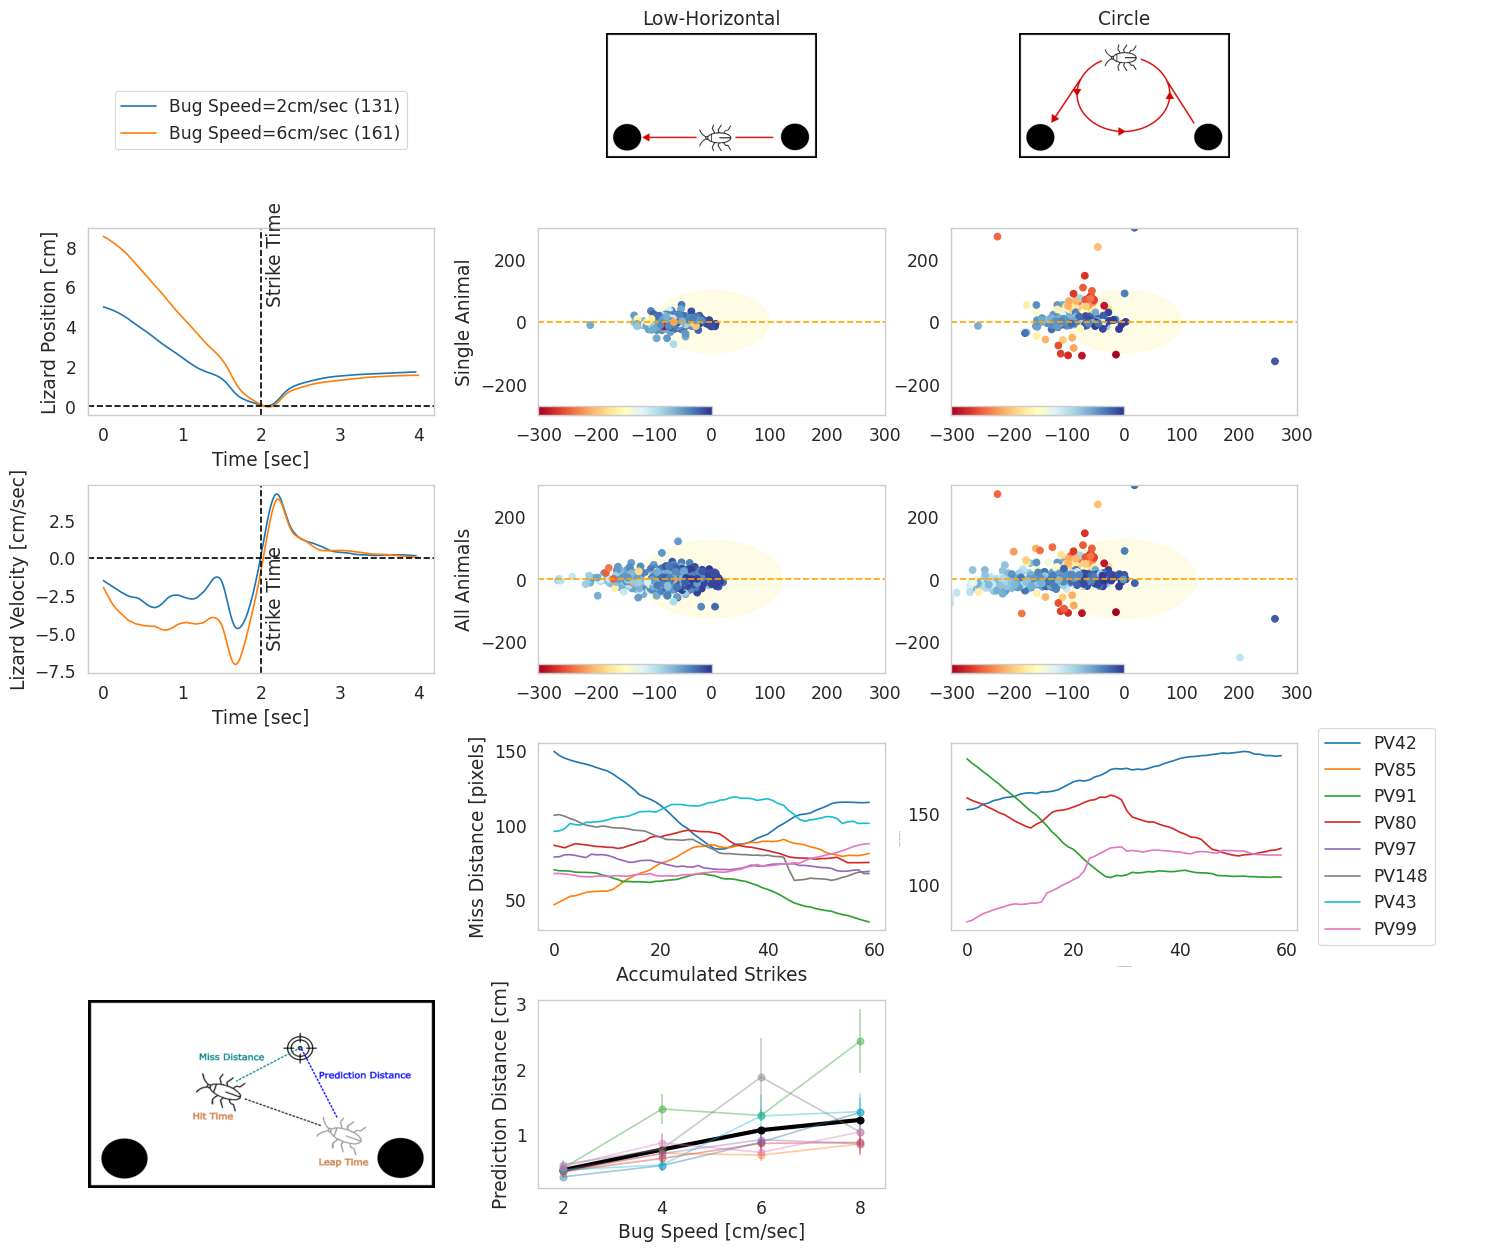

In [438]:
def plot_figure2():
    rows = 5
    # fig, axes = plt.subplots(rows, 4, figsize=(18, 3*rows), gridspec_kw={'height_ratios': [1.3,2,2,2,2]})
    fig = plt.figure(figsize=(18,3*rows))
    grid = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[6,4], wspace=0.1)
    left_grid = grid[0, 0].subgridspec(5, 2, height_ratios=[2,3,3,3,3], wspace=0.3, hspace=0.4)
    right_grid = grid[0, 1].subgridspec(5, 2, height_ratios=[2,3,3,3,3], width_ratios=[2,1], wspace=0.05, hspace=0.4)
    laxes = left_grid.subplots()
    raxes = right_grid.subplots()
    sns.set_context('paper', font_scale=1.4)
    single_animal = 'PV91'
    mts = {'random_low_horizontal': 'Low-Horizontal', 'circle': 'Circle'}
    for i, (mt, mt_label) in enumerate(mts.items()):
        if mt == 'random_low_horizontal':
            axes, col = laxes, 1
        else:
            axes, col = raxes, 0
        # projected single animal
        af_ = df.query(f'animal_id=="{single_animal}" and movement_type=="{mt}"')
        plot_projected(axes[1, col], af_)
        axes[0, col].set_title(mt_label)
        if i == 0:
            axes[1, col].set_ylabel('Single Animal')
        # projected all animals
        af_ = df.query(f'movement_type=="{mt}"')
        plot_projected(axes[2, col], af_)
        if i == 0:
            axes[2, col].set_ylabel('All Animals')
        # learning curves
        pd_lines = plot_learning_curve(axes[3, col], mt, labels_fontsize=None if i==0 else 0)
        if mt =='circle':
            axes[4, col].axis('off')
        else:
            plot_pred_distance(axes[4, col], mt, speeds=(2,4,6,8), labels_fontsize=None if i==0 else 0,
                               plot_only_with_all_speeds=mt=='random_low_horizontal')
        if mt == 'random_low_horizontal':
            raxes[3, 1].legend(handles=pd_lines, loc='center left')

        # for r in range(rows):
        #     axes[r, i].grid(False)

    # af_ = df.query(f'movement_type in {list(mts.keys())}').copy()
    # af_['movement_type'] = af_.movement_type.map(mts)
    # sns.kdeplot(data=af_.query(f'animal_id=="{single_animal}"'), y='proj_strike_y', hue='movement_type', ax=raxes[1,1], legend=False)
    # sns.kdeplot(data=af_, y='proj_strike_y', hue='movement_type', ax=raxes[2,1], legend=False)
    
    # plot_projected_histogram(axes[1, 2], af_.query(f'animal_id=="{single_animal}"'))
    # plot_projected_histogram(axes[2, 2], af_, is_plot_legend=False)
    
    sd_res = calc_strikes_dynamics(animal_id='PV91')
    sd_lines = plot_strikes_dynamics(sd_res, axes=laxes[1:3, 0], is_plot_legend=False)
    laxes[0, 0].legend(handles=sd_lines, loc='lower center')

    img = cv2.imread(f'{FIGURE_PATH}/assets/explain_prediction_distance.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    laxes[4, 0].imshow(img, aspect='auto')
    
    raxes[3, 1].grid(False)
    for i in range(rows):
        raxes[i, 1].axis('off')
        if i in [1, 2]:
            continue
        laxes[i, 0].axis('off')

    for i, img_path in enumerate(['low_horizontal.png', 'circle.png']):
        img = cv2.imread(f'{FIGURE_PATH}/assets/' + img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes, col = (laxes, 1) if i == 0 else (raxes, 0)
        axes[0, col].imshow(img)
        axes[0, col].axis('off')

    # fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure2.pdf')
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure2.png')


plot_figure2()

# Figure 3 - Jump Up

In [414]:
def get_time_from_prev_jump(ld):
    """return time in seconds from the closest jump before strike"""
    dt = np.nan
    try:
        traj = ld.traj_df.copy()
        jump_idx = np.where(traj.y.diff().abs() > 40)[0]

        if len(jump_idx) > 0:
            jump_idx_ = jump_idx[jump_idx < ld.bug_traj_strike_id]
            if len(jump_idx_):
                closest_jump_before = jump_idx_[-1]
                dt = (ld.traj_df.time[ld.bug_traj_strike_id] - ld.traj_df.time[closest_jump_before]).total_seconds()
    except Exception as exc:
        print(f'{ld}: {exc}')
    return dt


def calc_jumps(is_cache=True):
    cache_path = Path(f'{FIGURE_PATH}/cache/jump_up.pkl')
    if is_cache and cache_path.exists():
        with cache_path.open('rb') as f:
            jdf = pickle.load(f)
    else:
        jdf = df.query('movement_type=="jump_up" and time>="2023-05-25"').copy()
        jdf['y_pred_distance'] = None
        jdf['time_from_jump'] = None
        for i, row in tqdm(jdf.iterrows(), total=len(jdf)):
            try:
                ld = Loader(row.strike_id, 'front', orm=orm, is_debug=False)
                sa = StrikeAnalyzer(ld, is_y_pd=True)
                jdf.loc[i, 'y_pred_distance'] = sa.prediction_distance
                jdf.loc[i, 'time_from_jump'] = get_time_from_prev_jump(ld)
            except Exception as exc:
                continue
        with cache_path.open('wb') as f:
            pickle.dump(jdf, f)
                
    return jdf


def plot_jump_up_pd_misses(jdf, axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    animals_ids = ['PV91']
    for animal_id in animals_ids:
        jdf_ = jdf.query(f'0.005 <= time_from_jump <= 0.2 and animal_id=="{animal_id}"').sort_values(by='time')
        if jdf_.empty:
            continue
        block_ids, pds, misses = [], [], []
        for block_id, x in jdf_.groupby('block_id'):
            pds.append(x.y_pred_distance.abs().mean())
            misses.append(x.miss_distance.mean())
            block_ids.append(block_id)
        block_ids = [b - block_ids[0] for b in block_ids]
        misses = [pixels2cm(x) for x in misses]

        plot_regression(axes[0], np.array(block_ids), np.array(pds), color=COLORS[animal_id], prefix=animal_id)
        sns.scatterplot(x=block_ids, y=pds, ax=axes[0], color=COLORS[animal_id])
        axes[0].set_xlabel('Blocks')
        axes[0].set_ylabel(r'$\Delta$Y-Prediction-Distance [cm]')
        axes[0].grid(False)
        
        plot_regression(axes[1], np.array(block_ids), np.array(misses), color=COLORS[animal_id], prefix=animal_id)
        sns.scatterplot(x=block_ids, y=misses, ax=axes[1], color=COLORS[animal_id])
        axes[1].set_xlabel('Blocks')
        axes[1].set_ylabel('Misses [cm]')
        axes[1].grid(False)

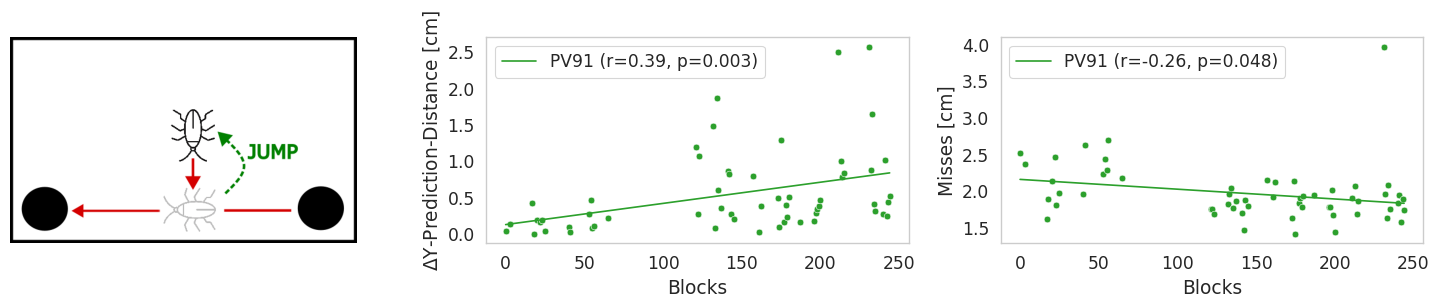

In [415]:
def plot_figure3():
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    
    jdf = calc_jumps()
    plot_jump_up_pd_misses(jdf, axes[1:3])
    
    img = cv2.imread(f'{FIGURE_PATH}/assets/jump.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img, aspect='equal')
    axes[0].axis('off')
    
    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure3.pdf')
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure3.png')
    
    
plot_figure3()

# Figure 4 - Occlusions

In [421]:
def occlusions_analysis(animal_ids):
    cache_path = Path(f'{FIGURE_PATH}/cache/occlusions_{animal_ids}.pkl')
    if cache_path.exists():
        with cache_path.open('rb') as f:
            pose_dict = pickle.load(f)
    else:
        with orm.session() as s:
            orm_res = s.query(Block, Experiment).join(Experiment, Experiment.id == Block.experiment_id).filter(
                Experiment.arena.in_(['reptilearn4', 'msi-regev']),
                Experiment.animal_id.in_(animal_ids),
                Experiment.animal_id.startswith('PV'),
                Experiment.start_time > '2023-04-18',
                Block.movement_type == 'rect_tunnel'
            ).all()
            
            dlc = DLCArenaPose('front', orm=orm)
            pose_dict = {}
            for blk, exp in orm_res:
                animal_id = exp.animal_id
                
                pose_df = []
                for vid in blk.videos:
                    try:
                        pdf_ = dlc.load(video_db_id=vid.id)
                        pose_df.append(pdf_)
                    except Exception:
                        pass
                if not pose_df:
                    continue
                pose_df = pd.concat(pose_df)
                pose_df.columns = ['_'.join(c) if c[1] else c[0] for c in pose_df.columns]
                pose_df['datetime'] = pd.to_datetime(pose_df['time'], unit='s')
                
                bug_trajs = []
                for tr in blk.trials:
                    if tr.bug_trajectory:
                        bug_trajs.extend(tr.bug_trajectory)
                if not bug_trajs:
                    continue
                bug_trajs = pd.DataFrame(bug_trajs)
                bug_trajs = bug_trajs.rename(columns={'x': 'bug_x', 'y': 'bug_y'})
                bug_trajs['time'] = pd.to_datetime(bug_trajs['time']).dt.tz_localize(None)
                bug_trajs = bug_trajs.sort_values(by='time')
                
                pose_df = pd.merge_asof(left=pose_df, right=bug_trajs, left_on='datetime', right_on='time', 
                                            direction='nearest', tolerance=pd.Timedelta('100 ms'))
                d_ = pose_dict.setdefault(animal_id, {})
                d_[blk.id] = pose_df
            with cache_path.open('wb') as f:
                pickle.dump(pose_dict, f)
    return pose_dict


def get_angles(pdf, bug_x_vec):
    xf = pdf.loc[~pdf.bug_x.isna()].copy()
    angs = []
    for group_id, gf in xf.groupby(xf.index.to_series().diff().ge(2).cumsum()):
        if gf.bug_x.iloc[0] > 50:
            continue
        # print(f'{gf.bug_x.iloc[0]} -> {gf.bug_x.iloc[-1]} ({gf.bug_x.diff().mean()})')
        y_ = gf.angle.map(math.degrees).values
        # x_ = gf.time_x.values - gf.time_x.iloc[0]
        x_ = gf.bug_x.values
        angs.append(np.interp(bug_x_vec, x_, y_))
    
    return np.vstack(angs)

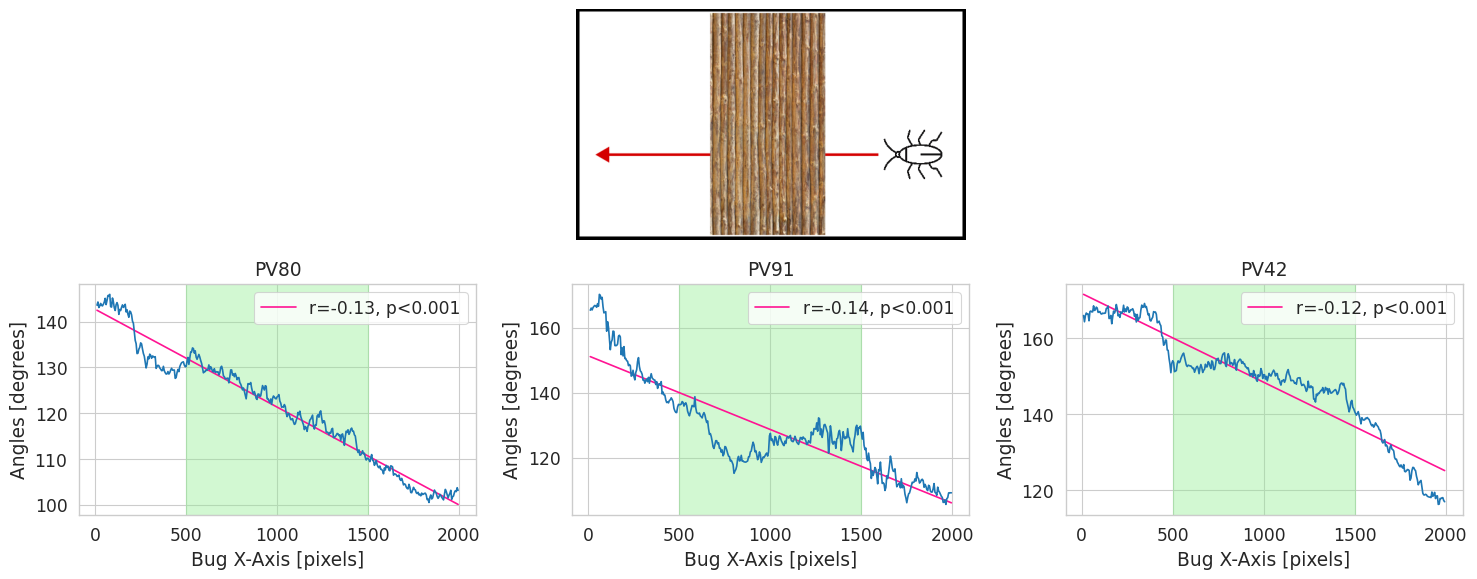

In [429]:
def plot_figure4():
    rect_pose = occlusions_analysis(['PV42', 'PV80', 'PV91'])
    fig, axes = plt.subplots(2, len(rect_pose), figsize=(15, 6))
    for i, (animal_id, d) in enumerate(rect_pose.items()):
        angles = []
        bug_x = np.arange(10, 2000, 5)
        for _, pdf in d.items():
            angles.append(get_angles(pdf, bug_x))
            
        angles = np.vstack(angles)
        plot_regression(axes[1, i], np.repeat(bug_x.reshape(1, -1), angles.shape[0], axis=0).flatten(), angles.flatten())
        axes[1, i].plot(bug_x, angles.mean(axis=0))
        axes[1, i].set_title(animal_id)
        ymin, ymax = axes[1, i].get_ylim()
        axes[1, i].add_patch(plt.Rectangle((500, ymin), 1000, ymax-ymin, color='lightgreen', alpha=0.4))
        axes[1, i].set_xlabel('Bug X-Axis [pixels]')
        axes[1, i].set_ylabel('Angles [degrees]')
    
    img = cv2.imread(f'{FIGURE_PATH}/assets/rect_tunnel.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, 1].imshow(img, aspect='equal')
    axes[0, 1].axis('off')
    
    for i in [0, 2]:
        axes[0, i].axis('off')
    
    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure4.pdf')
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure4.png')
        
plot_figure4()

# Figure 5 - Spatial Analysis

/home/regev/anaconda3/envs/Pogona_Pursuit/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


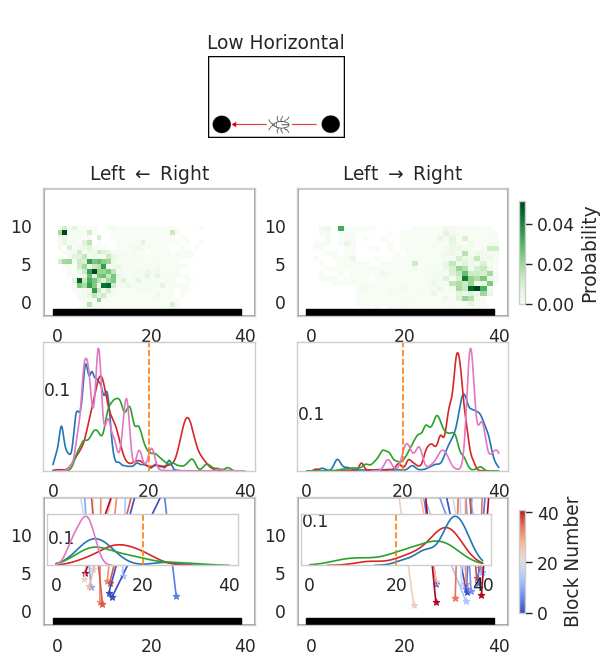

In [437]:
def plot_figure5(animal_id=None, single_animal='PV42', excluded_animals=None):
    if animal_id:
        animal_id = [animal_id]
    
    fig = plt.figure(figsize=(6, 8))
    grid = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[2, 5], hspace=0.01)
    
    movement_type = 'low_horizontal'
    rows = 3
    sa = SpatialAnalyzer(animal_ids=animal_id, movement_type=movement_type, start_date='2023-04-18',
                         split_by=['exit_hole'], bodypart='nose', is_use_db=True, excluded_animals=excluded_animals)
    inner_grid = grid[1, 0].subgridspec(rows, 2, wspace=0.2, hspace=0.2)
    axes = inner_grid.subplots()
    sa.plot_spatial_hist(single_animal, axes=axes[0, :], is_title=True, animal_colors=COLORS)
    sa.plot_spatial_x_kde(axes=axes[1, :], animal_colors=COLORS)
    sa.plot_trajectories(single_animal, axes=axes[2, :], only_to_screen=True, cbar_indices=[1], is_title=False,
                         animal_colors=COLORS)

    axes = grid[0, 0].subgridspec(1, rows).subplots()
    img = cv2.imread(f'{FIGURE_PATH}/assets/{movement_type}.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img, aspect='equal') # extent=[0, 10, 0, 10],
    axes[1].set_title('Low Horizontal')
    for i in range(rows):
        axes[i].axis('off')

    # fig.suptitle(animal_id[0] if animal_id else 'All Animals')
    # fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure5.pdf')
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure5.png')
    plt.show()
    
    
plot_figure5(excluded_animals=['PV85'])

### Engagement

In [6]:
def load_engagement():
    eng_ = []
    with orm.session() as s:
        exps = s.query(Experiment).filter(
            Experiment.arena.in_(['reptilearn4', 'msi-regev']),
            Experiment.animal_id.not_in(BAD_ANIMALS),
            Experiment.animal_id.startswith('PV'),
            Experiment.start_time > '2023-04-18').all()
        for exp in tqdm(exps):
            for blk in exp.blocks:
                # if blk.movement_type != 'random_low_horizontal':
                #     continue
                for tr in blk.trials:
                    trial_dict = {'trial_id': tr.id, 'animal_id': exp.animal_id, 'time': tr.start_time, 'is_strike': len(tr.strikes) > 0, 'block_id': blk.id, 'bug_speed': blk.bug_speed}
                    trial_dict['avg_miss'] = np.nanmean([np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) for strk in tr.strikes])
                    eng_.append(trial_dict)

    eng_ = pd.DataFrame(eng_)
    eng_['day'] = eng_.time.dt.floor('d').copy()
    for animal_id in eng_.animal_id.unique():
        af_ = eng_.query(f'animal_id=="{animal_id}"')
        first_day = af_.day.sort_values().iloc[0]
        eng_.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
    return eng_


def plot_engagement(n_trials=30):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    g = eng.groupby(['animal_id', 'block_id']).is_strike.agg(['sum', 'count']).reset_index()
    g['engagement'] = (g['sum'] / g['count']) * 100
    for animal_id in g.animal_id.unique():
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['engagement'] = savgol_filter(g_.engagement, window_length=15, polyorder=0, mode='nearest')
        axes[0].plot(g_.index, g_['engagement'], label=animal_id, color=COLORS[animal_id])
    axes[0].grid(False)
    axes[0].set_xlabel('Blocks')
    axes[0].set_ylabel('Engagement [%]\n(Percent of Engaged Trials per Block)')

    g = eng.query('is_strike').groupby(['animal_id', 'block_id']).agg({'avg_miss': np.nanmean}).reset_index()
    for animal_id in g.animal_id.unique():
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['avg_miss'] = savgol_filter(g_.avg_miss, window_length=19, polyorder=0, mode='nearest')
        axes[1].plot(g_.index, g_['avg_miss'], label=animal_id, color=COLORS[animal_id])
    axes[1].grid(False)
    axes[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    axes[1].set_xlabel('Blocks')
    axes[1].set_ylabel('Miss Distance [Pixels]')
    plt.tight_layout()
    plt.show()

eng = load_engagement()

  0%|          | 0/1396 [00:00<?, ?it/s]

/tmp/ipykernel_44741/2827526923.py:15: RuntimeWarning: Mean of empty slice
  trial_dict['avg_miss'] = np.nanmean([np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) for strk in tr.strikes])


<AxesSubplot:>

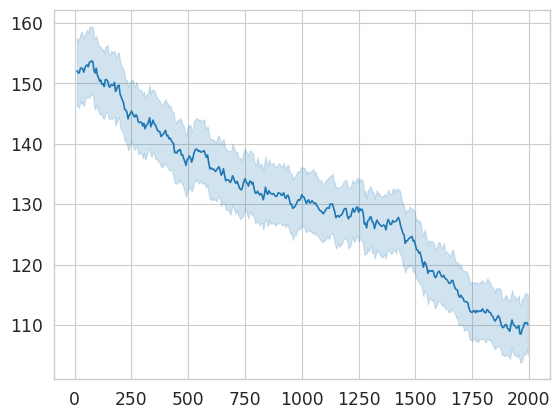

In [271]:
sns.lineplot(x=np.repeat(bug_x.reshape(1, -1), angles.shape[0], axis=0).flatten(), y=angles.flatten())
# np.repeat(bug_x.reshape(1, -1), 2, axis=0).shape

In [269]:
angles.shape

(1396, 398)

(-5.0, 5.0)

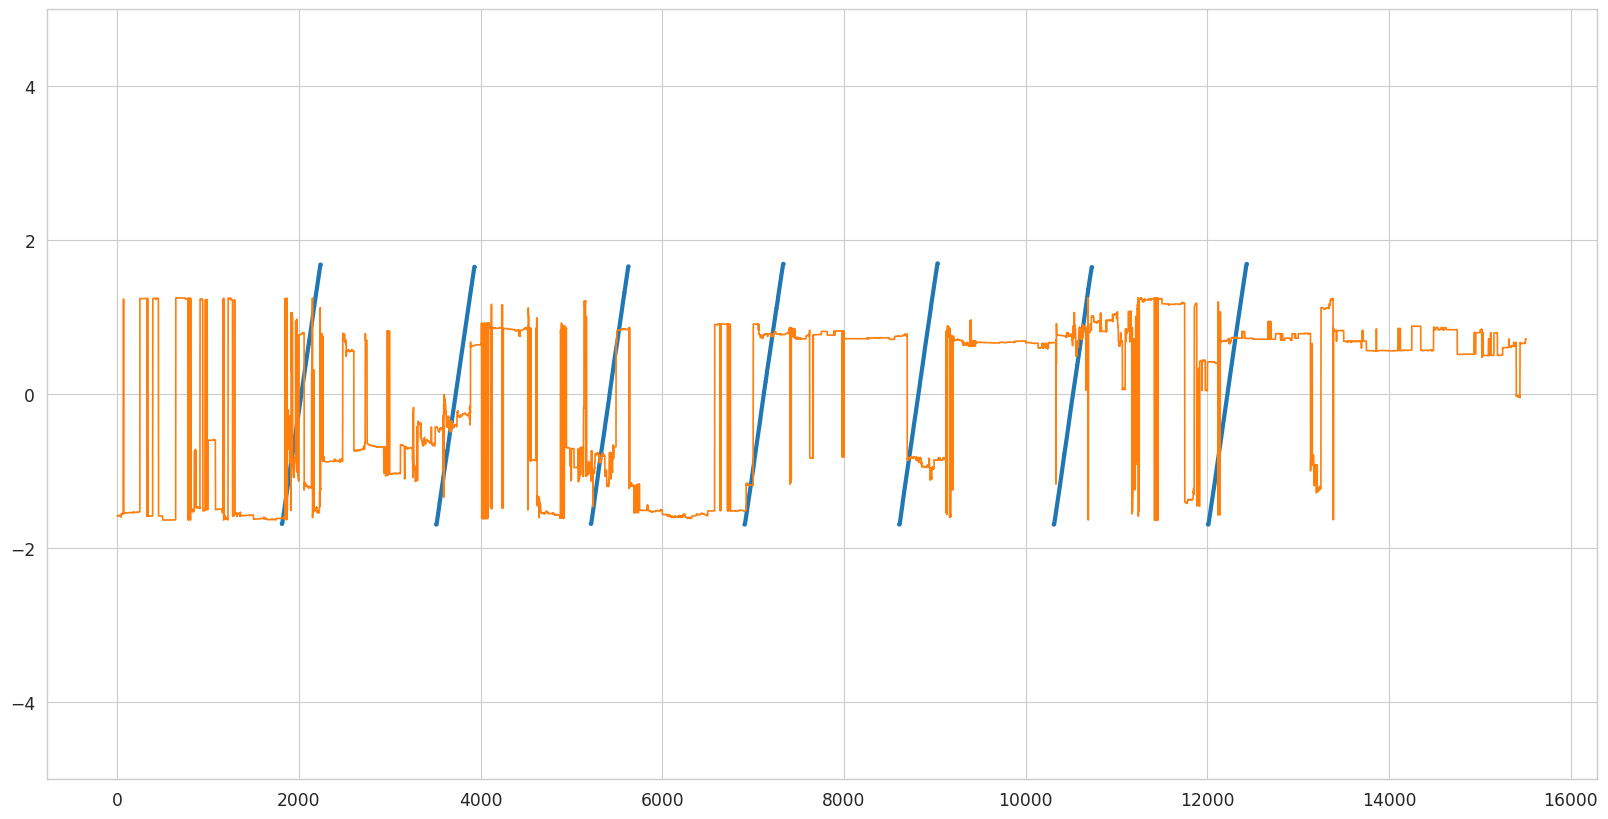

In [207]:


pdf = rect_pose[1838].copy()
pdf['gaze_proj'] = np.tan(pdf.angle) * pdf.nose_y 
plt.figure(figsize=(20, 10))
pdf_ = pdf.loc[~pdf.bug_x.isna()].copy()
pdf_['angle'] = pdf_['angle'].map(lambda x: math.degrees(x))
plt.plot((pdf.bug_x - pdf.bug_x.mean()) / pdf.bug_x.std(), linewidth=3)
# plt.plot((pdf.gaze_proj - pdf.gaze_proj.mean()) / pdf.gaze_proj.std())
plt.plot((pdf.angle - pdf.angle.mean()) / pdf.angle.std())
# sns.scatterplot(data=pdf_, x='bug_x', y='angle')
plt.ylim([-5, 5])

In [242]:
rect_pose[1838]

,left_ear_cam_x,left_ear_cam_y,left_ear_prob,mid_ears_cam_x,mid_ears_cam_y,mid_ears_prob,nose_cam_x,nose_cam_y,nose_prob,right_ear_cam_x,...,left_ear_y,right_ear_x,right_ear_y,angle,block_id,animal_id,datetime,time_y,bug_x,bug_y
0,869.380798,0.559578,0.005449,883.748840,-0.737197,0.003111,868.988403,0.179733,0.002024,898.116882,...,78.247368,5.294913,79.080831,0.120185,1838,PV80,2023-06-09 15:00:36.786668032,NaT,NaN,NaN
1,869.754333,0.546918,0.005329,883.900330,-0.733197,0.003014,869.308899,0.126080,0.001634,898.046326,...,78.251437,5.306577,79.074192,0.113988,1838,PV80,2023-06-09 15:00:36.803332096,NaT,NaN,NaN
2,869.745361,0.556046,0.005428,883.901794,-0.715630,0.003080,869.320129,0.135335,0.001619,898.058228,...,78.248503,5.304609,79.065834,0.112970,1838,PV80,2023-06-09 15:00:36.819997184,NaT,NaN,NaN
3,869.746155,0.548801,0.005321,883.901489,-0.717594,0.003029,869.328796,0.130835,0.001594,898.056885,...,78.250832,5.304831,79.064768,0.112705,1838,PV80,2023-06-09 15:00:36.836662016,NaT,NaN,NaN
4,869.749756,0.563926,0.005411,883.903198,-0.704124,0.003087,869.329102,0.138528,0.001620,898.056702,...,78.245971,5.304861,79.060971,0.111933,1838,PV80,2023-06-09 15:00:36.853327104,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15506,864.929382,2.636294,0.149169,888.070923,21.998278,0.116925,827.080688,3.590523,0.402667,911.212402,...,77.579995,3.130192,65.135673,5.120393,1838,PV80,2023-06-09 15:04:55.189928960,NaT,NaN,NaN
15507,864.927979,2.643515,0.150015,888.072510,22.011581,0.117611,827.082764,3.595974,0.402556,911.217041,...,77.577675,3.129425,65.129443,5.120304,1838,PV80,2023-06-09 15:04:55.206594048,NaT,NaN,NaN
15508,864.929077,2.637017,0.149278,888.071655,22.000217,0.116786,827.080994,3.590960,0.402844,911.214294,...,77.579763,3.129879,65.134658,5.120383,1838,PV80,2023-06-09 15:04:55.223258112,NaT,NaN,NaN
15509,864.930115,2.637237,0.149494,888.069214,22.000885,0.117640,827.082397,3.592728,0.403482,911.208313,...,77.579692,3.130868,65.134300,5.120347,1838,PV80,2023-06-09 15:04:55.239922944,NaT,NaN,NaN


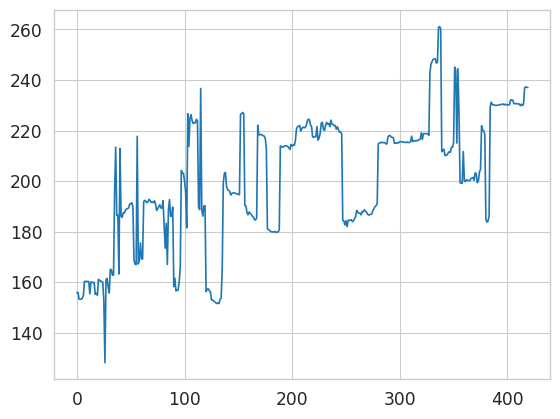

In [239]:
plt.plot(angles.mean(axis=0))

<AxesSubplot:xlabel='original', ylabel='calc'>

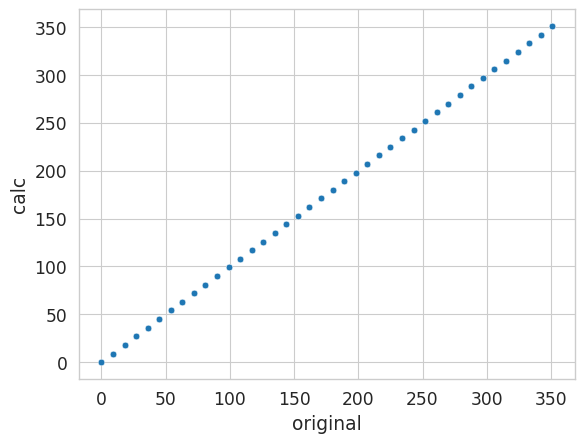

In [203]:
import math


def calc_head_angle(row):
    x_nose, y_nose = row.nose_x, row.nose_y
    x_ears = (row.right_ear_x + row.left_ear_x) / 2
    y_ears = (row.right_ear_y + row.left_ear_y) / 2
    dy = y_ears - y_nose
    dx = x_ears - x_nose
    if dx != 0.0:
        theta = np.arctan(abs(dy) / abs(dx))
    else:
        theta = np.pi / 2
    if dx > 0:  # looking south
        theta = np.pi - theta
    if dy < 0:  # looking opposite the screen
        theta = -1 * theta
    if theta < 0:
        theta = 2 * np.pi + theta
    return math.degrees(theta)

center_x, center_y = 20, 10
res = []
for th in np.arange(0, 2*np.pi, np.pi/20):
    x = center_x + 5 * np.cos(th)
    y = center_y - 5 * np.sin(th)
    s = pd.Series({'nose_x': x, 'nose_y': y, 'right_ear_x': center_x + 5, 'right_ear_y': center_y, 
                   'left_ear_x': center_x - 5, 'left_ear_y': center_y})
    calc_th = calc_head_angle(s)
    res.append({'original': math.degrees(th), 'calc': calc_th})
res = pd.DataFrame(res)
sns.scatterplot(data=res, x='original', y='calc')

In [200]:
np.cos(0)

1.0

Strike-1005: traj_df is empty
Strike-1007: traj_df is empty
Strike-1006: traj_df is empty
Strike-1051: traj_df is empty
Strike-1052: traj_df is empty
Strike-1068: traj_df is empty
Strike-1069: traj_df is empty
Strike-1071: traj_df is empty
Strike-1072: traj_df is empty
Strike-1073: traj_df is empty
Strike-1074: traj_df is empty
Strike-1070: traj_df is empty
Strike-1083: traj_df is empty
Strike-1230: traj_df is empty
Strike-1231: traj_df is empty
Strike-1233: traj_df is empty
Strike-1234: traj_df is empty
Strike-1235: traj_df is empty
Strike-1232: traj_df is empty


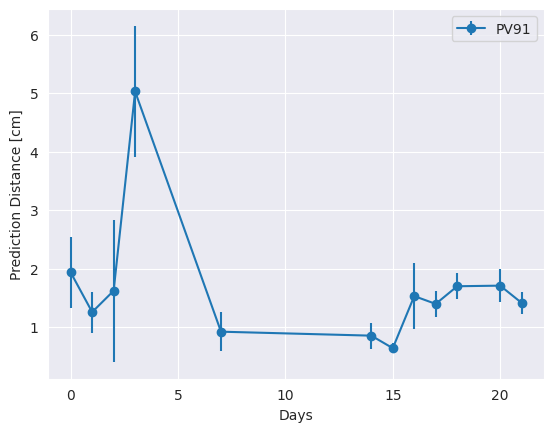

In [19]:
ax = plt.subplot()
for animal_id in df.animal_id.unique():
    if animal_id in ['PV80', 'PV85']:
        continue
    af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="jump_up"').copy()
    af_['time_from_jump'] = af_.strike_id.map(get_time_from_prev_jump)
    
    af_ = af_.query('0.005 <= time_from_jump <= 0.3')
    # af_.dropna(subset=['pred_distance'], inplace=True)
    # af_ = af_.sort_values(by='strike_id').reset_index()
    if af_.empty:
        continue
    # y = savgol_filter(af_.pred_distance, window_length=41, polyorder=0, mode='nearest')
    # ax.plot(af_.index, y, label=animal_id)
    
    if af_.day_num.min() > 0:
        af_['day_num'] = af_.day_num - af_.day_num.min()
    af_.dropna(subset=['pred_distance'], inplace=True)
    g_ = af_.groupby('day_num').pred_distance.agg(['mean', 'sem'])
    g_.dropna(inplace=True)
    ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], label=animal_id, fmt='-o', color=COLORS[animal_id])
    # plot_regression(ax, af_.round_speed.values, af_.pred_distance.values)

ax.set_xlabel('Days')
ax.set_ylabel('Prediction Distance [cm]')
ax.legend()

In [ ]:
ld = Loader(397, 'front', orm=orm, sec_before=5, sec_after=5, is_debug=False)
sa = StrikeAnalyzer(ld, is_y_pd=True)
# y = interpolate_y(sa.pose_df)
y = sa.pose_df.reset_index().y
# plt.plot(sa.pose_df.reset_index().y)
# plt.plot(y)

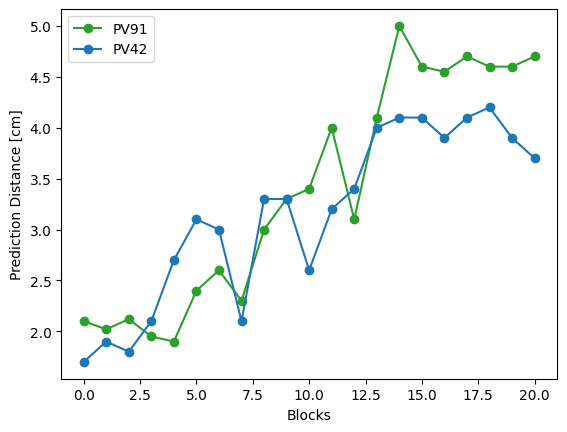

In [165]:
jumps = {
    'PV91': [2.1, 2.02, 2.12, 1.95, 1.9, 2.4, 2.6, 2.3, 3, 3.3, 3.4, 4, 3.1, 4.1, 5, 4.6, 4.55, 4.7, 4.6, 4.6, 4.7],
    'PV42': [1.7, 1.9, 1.8, 2.1, 2.7, 3.1, 3, 2.1, 3.3, 3.3, 2.6, 3.2, 3.4, 4, 4.1, 4.1, 3.9, 4.1, 4.2, 3.9, 3.7]
}

for animal_id, l in jumps.items():
    plt.plot(np.arange(len(l)), l, '-o', color=COLORS[animal_id], label=animal_id)

plt.xlabel('Blocks')
plt.ylabel('Prediction Distance [cm]')
plt.legend()

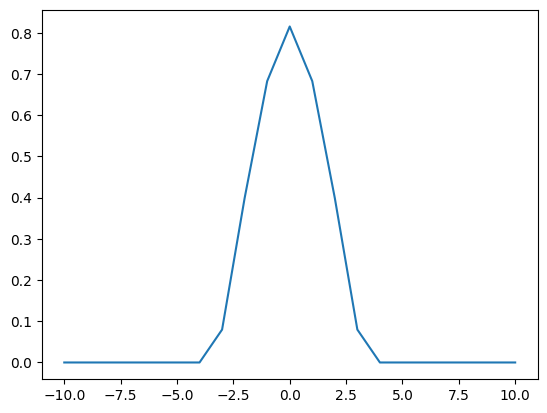

In [176]:
l = [(-10, 0),
(-9, 0),
(-8, 0),
(-7, 0),
(-6, 0),
(-5, 0),
(-4, 0),
(-3, 0.079788456),
(-2, 0.39894228),
(-1, 0.68268949),
(0, 0.81536437),
(1, 0.68268949),
(2, 0.39894228),
(3, 0.079788456),
(4, 0),
(5, 0),
(6, 0),
(7, 0),
(8, 0),
(9, 0),
(10, 0)
]
l = np.array(l)


plt.plot(l[:, 0], l[:, 1])

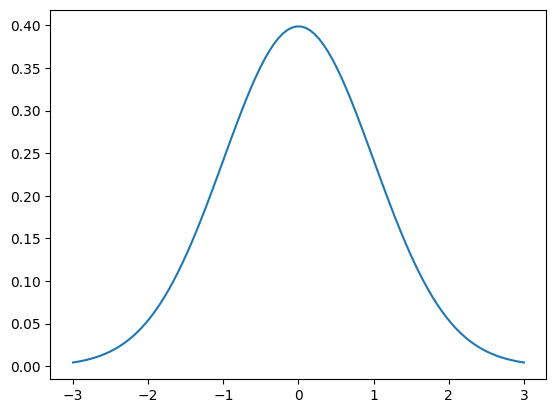

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

Text(0.5, 0, 'Horizontal Axis [cm]')

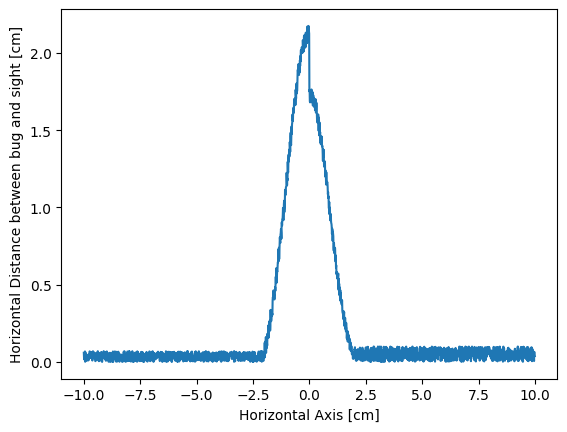

In [215]:
import random

x1 = np.arange(-10, -2, 0.01)
x2 = np.arange(-2, 2, 0.01)
x3 = np.arange(2, 10, 0.01)

y1 = np.zeros((len(x1),)) + 0.07 * np.array([random.random() for _ in range(len(x1))])
y3 = np.zeros((len(x3),)) + 0.1 * np.array([random.random() for _ in range(len(x3))])
y2 = stats.norm.pdf(x2, mu, sigma)
y2 = y2 - y2.min() + 0.02 * np.array([random.random() for _ in range(len(x2))])
y2[len(y2) // 2:] = y2[len(y2) // 2:] ** 1.2
y2 = y2 * 6
plt.plot(np.hstack([x1, x2, x3]), np.hstack([y1, y2, y3]))
plt.ylabel('Horizontal Distance between bug and sight [cm]')
plt.xlabel('Horizontal Axis [cm]')

In [178]:
stats.norm.pdf(x, mu, sigma) + random.random

array([0.00443185, 0.00530579, 0.00632878, 0.00752133, 0.00890582,
       0.0105065 , 0.01234943, 0.01446241, 0.01687483, 0.01961746,
       0.02272223, 0.02622189, 0.03014961, 0.03453857, 0.03942137,
       0.0448295 , 0.05079264, 0.05733801, 0.06448952, 0.07226707,
       0.08068571, 0.08975477, 0.09947714, 0.10984842, 0.12085626,
       0.13247967, 0.14468855, 0.15744319, 0.17069405, 0.18438164,
       0.1984366 , 0.21277993, 0.22732351, 0.24197072, 0.2566174 ,
       0.27115285, 0.28546117, 0.29942268, 0.31291556, 0.3258175 ,
       0.33800759, 0.34936814, 0.35978656, 0.36915722, 0.37738323,
       0.38437808, 0.3900672 , 0.39438923, 0.39729716, 0.39875915,
       0.39875915, 0.39729716, 0.39438923, 0.3900672 , 0.38437808,
       0.37738323, 0.36915722, 0.35978656, 0.34936814, 0.33800759,
       0.3258175 , 0.31291556, 0.29942268, 0.28546117, 0.27115285,
       0.2566174 , 0.24197072, 0.22732351, 0.21277993, 0.1984366 ,
       0.18438164, 0.17069405, 0.15744319, 0.14468855, 0.13247

In [14]:
ld = Loader(703, 'front', is_debug=False, orm=orm, sec_before=2, sec_after=6)

left_ear                 mid_ears                        nose  \
        cam_x cam_y      prob    cam_x cam_y      prob       cam_x   
1893      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
1894      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
1895      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
1896      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
1897      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   
...       ...   ...       ...      ...   ...       ...         ...   
2369      NaN   NaN  0.000010      NaN   NaN  0.000071         NaN   
2370      NaN   NaN  0.000084      NaN   NaN  0.000050         NaN   
2371      NaN   NaN  0.000788      NaN   NaN  0.000570  870.688171   
2372      NaN   NaN  0.000011      NaN   NaN  0.000377         NaN   
2373      NaN   NaN  0.000010      NaN   NaN  0.000013         NaN   

                           right_ear  ...  vy  ax  ay      nose             \
           cam_y      prob     cam_x  ...                     x          y   
1893         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
1894         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
1895         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
1896         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
1897         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   
...          ...       ...       ...  ...  ..  ..  ..       ...        ...   
2369         NaN  0.000031       NaN  ... NaN NaN NaN       NaN        NaN   
2370         NaN  0.071453       NaN  ... NaN NaN NaN       NaN        NaN   
2371  429.577515  0.923372       NaN  ... NaN NaN NaN  4.912532  14.547394   
2372         NaN  0.020929       NaN  ... NaN NaN NaN       NaN        NaN   
2373         NaN  0.000015       NaN  ... NaN NaN NaN       NaN        NaN   

     left_ear     right_ear     angle  
            x   y         x   y        
1893      NaN NaN       NaN NaN   NaN  
1894      NaN NaN       NaN NaN   NaN  
1895      NaN NaN       NaN NaN   NaN  
1896      NaN NaN       NaN NaN   NaN  
1897      NaN NaN       NaN NaN   NaN  
...       ...  ..       ...  ..   ...  
2369      NaN NaN       NaN NaN   NaN  
2370      NaN NaN       NaN NaN   NaN  
2371      NaN NaN       NaN NaN   NaN  
2372      NaN NaN       NaN NaN   NaN  
2373      NaN NaN       NaN NaN   NaN  

[481 rows x 26 columns]

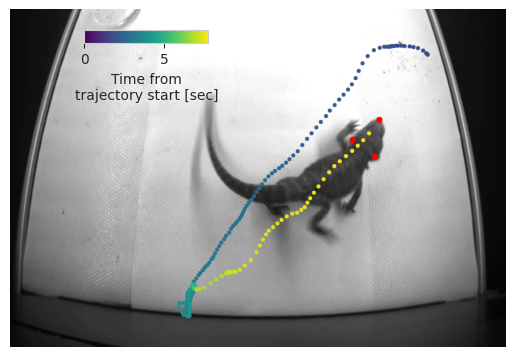

In [63]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ld = Loader(725, 'front', is_debug=False, orm=orm, sec_before=4, sec_after=3.8)
xf = ld.frames_df.dropna(subset=[('nose', 'cam_x')])['nose']
x = np.linspace(0, 1, len(xf))
cmap = mpl.colormaps['viridis']
cmap_mat = (cmap(x)[:, :3] * 255).astype(int)
last_frame_id = xf.index[-2]
_, frame = next(ld.gen_frames([last_frame_id]))
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
for i, row in xf.iloc[:-3].reset_index(drop=True).iterrows():
    color = cmap_mat[i, :].tolist()
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 6, color, -1)

for bp in ['nose', 'left_ear', 'right_ear']:
    row = ld.frames_df[bp].loc[last_frame_id]
    if np.isnan(row.cam_x):
        continue
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 9, (255, 0, 0), -1)

plt.figure()
frame = frame[100:, :]
plt.imshow(frame)
plt.grid(False)
plt.axis('off')
secs = (xf.index.values - xf.index[0]) / 60

# cbaxes = inset_axes(plt.gca(), width="30%", height="3%", loc='upper left')
cbaxes = plt.gca().inset_axes([0.15, 0.9, 0.25, 0.04])
mpl.colorbar.ColorbarBase(cbaxes, cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=secs.max()), orientation='horizontal', label='Time from\ntrajectory start [sec]')

In [39]:
secs.max()

6.0

In [17]:
ld = Loader(708, 'front', is_debug=False, orm=orm, sec_before=4, sec_after=20)
ld.play_strike(ld.n_frames_back, ld.n_frames_forward)

In [ ]:
for j in range(700, 750):
    ld = Loader(j, 'front', is_debug=False, orm=orm, sec_before=4, sec_after=6)
    xf = ld.frames_df.dropna(subset=[('nose', 'cam_x')])['nose']
    x = np.linspace(0, 1, len(xf))
    cmap_mat = (mpl.colormaps['viridis'](x)[np.newaxis, :, :3] * 255).astype(int).squeeze()
    last_frame_id = xf.index[-2]
    _, frame = next(ld.gen_frames([last_frame_id]))
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    for i, row in xf.reset_index(drop=True).iterrows():
        color = cmap_mat[i, :].tolist()
        frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 8, color, -1)

    plt.figure()
    plt.imshow(frame)
    plt.title(str(j))

In [59]:
cmap_mat

array([[ 68,   1,  84],
       [ 68,   1,  84],
       [ 68,   2,  85],
       [ 68,   3,  87],
       [ 69,   5,  88],
       [ 69,   5,  88],
       [ 69,   6,  90],
       [ 69,   8,  91],
       [ 70,   9,  92],
       [ 70,  11,  94],
       [ 70,  11,  94],
       [ 70,  12,  95],
       [ 70,  14,  97],
       [ 71,  15,  98],
       [ 71,  17,  99],
       [ 71,  17,  99],
       [ 71,  18, 101],
       [ 71,  20, 102],
       [ 71,  21, 103],
       [ 71,  22, 105],
       [ 71,  22, 105],
       [ 71,  24, 106],
       [ 72,  25, 107],
       [ 72,  26, 108],
       [ 72,  28, 110],
       [ 72,  28, 110],
       [ 72,  29, 111],
       [ 72,  30, 112],
       [ 72,  32, 113],
       [ 72,  33, 114],
       [ 72,  33, 114],
       [ 72,  34, 115],
       [ 72,  35, 116],
       [ 71,  37, 117],
       [ 71,  38, 118],
       [ 71,  38, 118],
       [ 71,  39, 119],
       [ 71,  40, 120],
       [ 71,  42, 121],
       [ 71,  43, 122],
       [ 71,  43, 122],
       [ 71,  44

In [200]:
orm = ORM()

In [201]:
with orm.session() as s:
    vids = s.query(Video).all()

In [ ]:
for vid in tqdm(vids):
    try:
        path = Path(vid.path)
        frames_dir = path.parent / 'frames_timestamps'
        frames_dir.mkdir(exist_ok=True)
        output_path = frames_dir / path.with_suffix('.csv').name
        if not output_path.exists():
            pd.Series(vid.frames).to_csv(output_path)
            print(vid.path)
    except Exception as exc:
        print(f'Error in {vid.path}; {exc}')